In [16]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from transformers import SegformerForSemanticSegmentation
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [17]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-cityscapes-1024-1024")

dataset_path = '../small_gtFine_trainvaltest'
save_dir = '~'
batch_size = 1

model.eval()
normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def denormalize(tensor):
    tensor = tensor.clone()  # Clone the tensor so as not to make changes to the original
    for t, m, s in zip(tensor, normalization.mean, normalization.std):
        t.mul_(s).add_(m)  # Multiply by std and add mean
    tensor = torch.clamp(tensor, 0, 1)  # Clamp values to the range [0, 1]
    return tensor
def plot_segmentation(images, targets, preds, save_dir):
    images = denormalize(images)  # Denormalize the image
    images = images.cpu().numpy()  # Convert to numpy array
    targets = targets.cpu().numpy()  # Convert to numpy array
    preds = preds.cpu().numpy()  # Convert to numpy array
    fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    axs[0].imshow(np.transpose(images[0], (1, 2, 0)))  # Original image
    axs[0].set_title('Original Image')

    # Class names and their corresponding colors
    class_names = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
                   'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
                   'bicycle', 'other']
    colors = ['black', 'gray', 'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'cyan',
              'magenta', 'olive', 'lime', 'teal', 'coral', 'indigo', 'maroon', 'navy', 'white']

    cmap = mcolors.ListedColormap(colors)
    # Assign colors to each class index based on the specified 'colors'
    legend_handles = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(colors))]

    # Create patches as legend handles

    #plot each class with a different color, values in preds are from 0 to 18
    # use colors to represent each class

    #0-19
    axs[1].imshow(targets[0], cmap=cmap, vmin=0, vmax=19)
    axs[1].set_title('Ground Truth')
    #0-18
    axs[2].imshow(preds[0], cmap=cmap, vmin=0, vmax=19)
    axs[2].set_title('Predicted Segmentation')
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")
    plt.tight_layout()
    plt.show()

In [18]:
mapping_20 = {
    0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19, 7: 0, 8: 1, 9: 19,
    10: 19, 11: 2, 12: 3, 13: 4, 14: 19, 15: 19, 16: 19, 17: 5, 18: 19,
    19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13,
    27: 14, 28: 15, 29: 19, 30: 19, 31: 16, 32: 17, 33: 18, -1: 19}
def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask

def transform_target(target):
    target = np.array(target)  # Convert PIL Image to numpy array
    target = encode_labels(target)  # Remap labels
    return torch.as_tensor(target, dtype=torch.int64)  # Convert numpy array to tensor

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transform_target
])

class DynamicSquareSplitDataset(datasets.Cityscapes):
    def __init__(self, root, split, mode='fine', target_type='semantic', transform=None, target_transform=None, square_size=512):
        super().__init__(root, split=split, mode=mode, target_type=target_type)
        self.transform = transform
        self.target_transform = target_transform
        self.square_size = square_size

    def __getitem__(self, index):
        patches_per_row = 2048 // self.square_size
        patches_per_col = 1024 // self.square_size
        patches_per_image = patches_per_row * patches_per_col
        image_index = index // patches_per_image
        patch_index = index % patches_per_image
        row_index = patch_index // patches_per_row
        col_index = patch_index % patches_per_row

        image, mask = super(DynamicSquareSplitDataset, self).__getitem__(image_index)
        top = row_index * self.square_size
        left = col_index * self.square_size
        image_patch = TF.crop(image, top, left, self.square_size, self.square_size)
        mask_patch = TF.crop(mask, top, left, self.square_size, self.square_size)

        if self.transform:
            image_patch = self.transform(image_patch)
        if self.target_transform:
            mask_patch = self.target_transform(mask_patch)

        return image_patch, mask_patch

    def __len__(self):
        return len(self.images) * (2048 // self.square_size) * (1024 // self.square_size)

# Define the dataset with appropriate transforms for both images and targets
square_size = 1024
train_dataset = DynamicSquareSplitDataset(root=dataset_path, split='train', square_size=square_size,transform=transform, target_transform=target_transform)
val_dataset = DynamicSquareSplitDataset(root=dataset_path, split='val', square_size=square_size, transform=transform, target_transform=target_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"training on {device}")
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # learning rate decay，reduce the learning rate by a factor of 0.1 every 7 epochs


training on cpu


mIoU: 0.5526702923266412


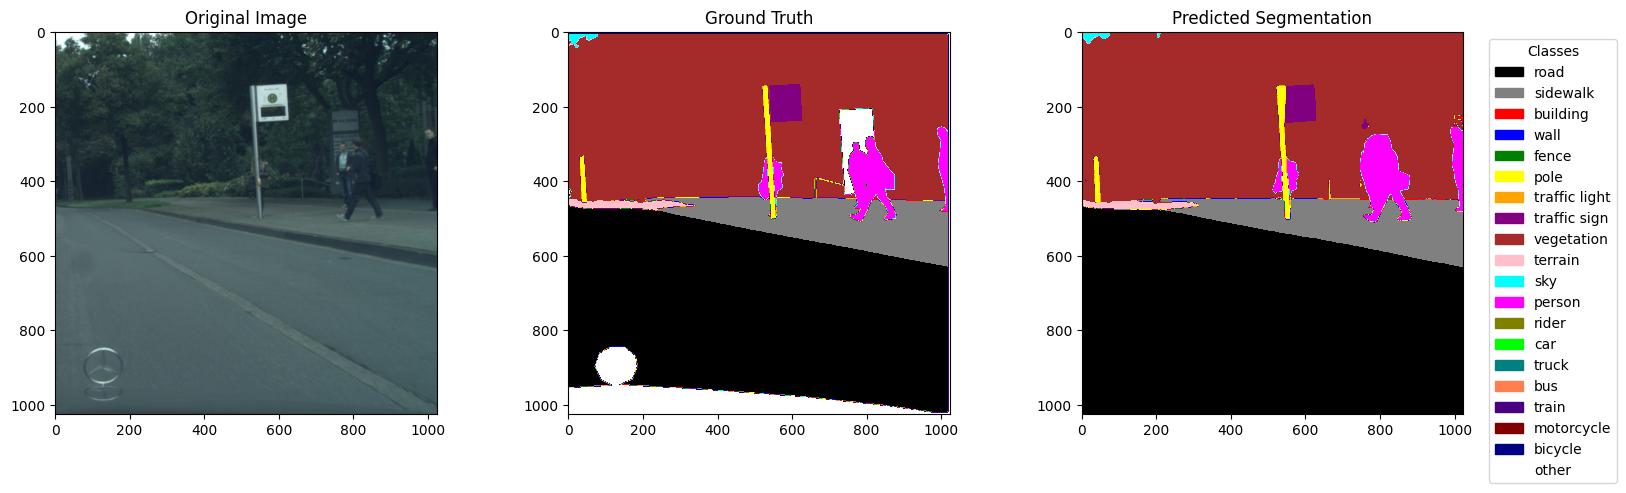

In [19]:
# Validation phase
model.eval()
num_classes = 20
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).long()
        optimizer.zero_grad()

        outputs = model(images)
        logits = outputs.logits
        logits = F.interpolate(logits, size=(1024, 1024), mode='bilinear', align_corners=False)
        targets = masks

        _, predicted = torch.max(logits,
                                 1)  # max is used to get the index of the class with the highest probability

        iou_per_class = []
        # calculate MIoU here:
        for cls in range(num_classes):
            predicted_cls = predicted == cls
            target_cls = targets == cls
            intersection = (predicted_cls & target_cls).sum().item()
            union = (predicted_cls | target_cls).sum().item()
            if union == 0:
                iou_per_class.append(float('nan'))  # Avoid division by zero
            else:
                iou_per_class.append(intersection / union)
        mIOU = np.nanmean(iou_per_class)
        print(f"mIoU: {mIOU}")
        plot_segmentation(images, targets, predicted, save_dir)
        break